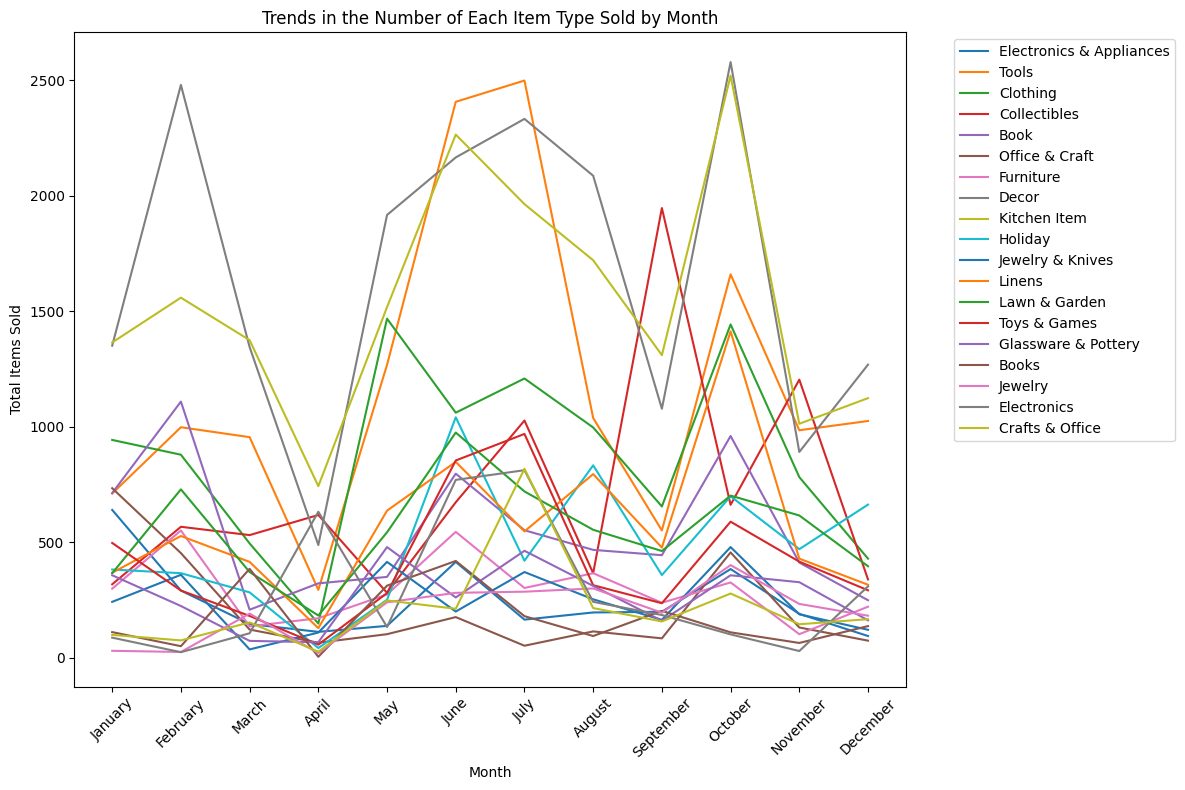

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the JSON data
with open('output.json', 'r') as file:
    data = json.load(file)

# Initialize a dictionary to collect monthly data
monthly_data = {}

# Process the JSON data
for record in data.values():
    month = record['sale_date']
    item_summary = record['csv_data']['item_summary']

    if month not in monthly_data:
        monthly_data[month] = {}

    for item, details in item_summary.items():
        monthly_data[month][item] = monthly_data[month].get(item, 0) + details['total_sold']

# Convert the data into a DataFrame
df = pd.DataFrame.from_dict(monthly_data, orient='index').fillna(0)
df.index.name = 'Month'

# Reorder months
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
df = df.reindex(month_order)

# Filter out items with less than 500 total sales across all months
total_sales = df.sum()
filtered_items = total_sales[total_sales >= 2000].index
df = df[filtered_items]

# Plot trends for each item type
plt.figure(figsize=(12, 8))
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

plt.title('Trends in the Number of Each Item Type Sold by Month')
plt.xlabel('Month')
plt.ylabel('Total Items Sold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the item_type
encoder = OneHotEncoder(sparse_output=False)  # Updated argument
item_type_encoded = encoder.fit_transform(df[['item_type']])

# Convert to DataFrame and concatenate with the original features
item_type_df = pd.DataFrame(item_type_encoded, columns=encoder.get_feature_names_out(['item_type']))
X = pd.concat([df[['month', 'latitude', 'longitude', 'square_footage', 'property_value']], item_type_df], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_sold_train, y_sold_test = train_test_split(X, y_total_sold, test_size=0.1, random_state=33)
_, _, y_price_train, y_price_test = train_test_split(X, y_average_price, test_size=0.1, random_state=18)
_, _, y_sales_train, y_sales_test = train_test_split(X, y_total_sales, test_size=0.1, random_state=46)

# Train models for each target
model_sold = RandomForestRegressor(random_state=85)
model_price = RandomForestRegressor(random_state=10)
model_sales = RandomForestRegressor(random_state=56)

model_sold.fit(X_train, y_sold_train)
model_price.fit(X_train, y_price_train)
model_sales.fit(X_train, y_sales_train)

# Evaluate models
pred_sold = model_sold.predict(X_test)
pred_price = model_price.predict(X_test)
pred_sales = model_sales.predict(X_test)

print("Total Sold MSE:", mean_squared_error(y_sold_test, pred_sold))
print("Average Price MSE:", mean_squared_error(y_price_test, pred_price))
print("Total Sales MSE:", mean_squared_error(y_sales_test, pred_sales))

# Display updated results
# Display updated results
def display_results():
    # Align indices between the original DataFrame and X_test
    original_indices = df.index[X_test.index]  # Use the original DataFrame indices

    results = pd.DataFrame({
        'Address': df.loc[original_indices, 'address'].values,
        'Item Type': df.loc[original_indices, 'item_type'].values,
        'True Total Sold': y_sold_test.values,
        'Predicted Total Sold': pred_sold,
        'True Average Price': y_price_test.values,
        'Predicted Average Price': pred_price,
        'True Total Sales': y_sales_test.values,
        'Predicted Total Sales': pred_sales
    })

    grouped_results = results.groupby('Address')
    print("\nResults from Test Set:\n")
    for address, group in grouped_results:
        print(f"Address: {address}\n")
        print(group.to_string(index=False))
        print("\n" + "-" * 50 + "\n")

display_results()



Total Sold MSE: 16282.65813953665
Average Price MSE: 450.5585004696317
Total Sales MSE: 1261527.1086008966

Results from Test Set:

Address: 1005 Wellington Court Lenoir, NC

                         Address Item Type  True Total Sold  Predicted Total Sold  True Average Price  Predicted Average Price  True Total Sales  Predicted Total Sales
1005 Wellington Court Lenoir, NC   Jewelry                6                 42.01                9.33                13.915667            153.25               528.2956

--------------------------------------------------

Address: 1019 Wellington Ct. Lenoir, NC 28645

                             Address Item Type  True Total Sold  Predicted Total Sold  True Average Price  Predicted Average Price  True Total Sales  Predicted Total Sales
1019 Wellington Ct. Lenoir, NC 28645    Linens              104                138.78                2.53                14.562083             88.75              309.85625

--------------------------------------------